In [1]:
# Preprocessed Data: Trimmed and Filtered 
# Handcraft features: MFCC sample_rate = 48000, n_mfcc=20, n_fft = 2048, hop_length = 512, power = 2
# Learned features via: 2Layer-2D-CNN-GRU network 
# Adams Optimiser 
# 32 batch size for training

In [2]:
import os
import torch
import torchaudio
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
import scipy
import math
from scipy import signal
import librosa.display
import torch.nn as nn
import statistics
from torch.utils.data import DataLoader
torch.backends.cudnn.benchmark = True

MODEL_PATH = './model/ravdess_NN_2L-CNN-GRU_32_CV'
NPARR_PATH = './array/ravdess_NN_2L-CNN-GRU_32_CV accuracies.npz'

/home/bryanleow/FYP/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
def set_seed(sd):
    np.random.seed(sd)
    random.seed(sd)
    random.Random(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set to:{}".format(sd))
# also set worker_init_fn=np.random.seed(0),num_workers=4, pin_memory=True in dataloader   

set_seed(42)

Seed set to:42


## 1. CV Dataset for Ravdess

In [4]:
class RavdessDataset2(object):
    """
        Create a Dataset for RAVDESS. Each item is a tuple of the form:
        (waveform, sample_rate, emotion, speaker)
    """ 
    
    # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    _emotions = { '01': 0, '02': 1, '03': 2, '04': 3, '05': 4, '06': 5, '07': 6, '08': 7 }
 
    _speaker = {'Actor_0'+ str(i+1): i for i in range(24) if i< 9}
    _speaker.update({'Actor_'+ str(i+1): i for i in range(24) if i>= 9})
    
    rev_speaker = {i: 'Actor_0' + str(i+1) for i in range(24) if i<9}
    rev_speaker.update({i: 'Actor_' + str(i+1) for i in range(24) if i>=9})
    
    def __init__(self, root, cv_index, split):
        """
        Args:
            root (string): Directory containing the wav files
            split(string): Either train, validate or test set
        """
        self.root = root
        self.data = []
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])
        self.allActors = ['Actor_0'+ str(i+1) for i in range(24)if i<9] + ['Actor_'+ str(i+1) for i in range(24)if i>=9]
        
        self.cv = { 0:  (['Actor_01','Actor_02'],['Actor_03','Actor_04']),
                    1:  (['Actor_03','Actor_04'],['Actor_05','Actor_06']),
                    2:  (['Actor_05','Actor_06'],['Actor_07','Actor_08']),
                    3:  (['Actor_07','Actor_08'],['Actor_09','Actor_10']),
                    4:  (['Actor_09','Actor_10'],['Actor_11','Actor_12']),
                    5:  (['Actor_11','Actor_12'],['Actor_13','Actor_14']),
                    6:  (['Actor_13','Actor_14'],['Actor_15','Actor_16']),
                    7:  (['Actor_15','Actor_16'],['Actor_17','Actor_18']),
                    8:  (['Actor_17','Actor_18'],['Actor_19','Actor_20']),
                    9:  (['Actor_19','Actor_20'],['Actor_21','Actor_22']),
                    10: (['Actor_21','Actor_22'],['Actor_23','Actor_24']),
                    11: (['Actor_23','Actor_24'],['Actor_01','Actor_02'])
                  }

        # Iterate through all audio files
        for root, dirs, files in os.walk(root):
            if split == 'train':
                if root[-8:] in [x for x in self.allActors if x not in (self.cv[cv_index][0]+ self.cv[cv_index][1])]:
                    for file in files:
                        self.data.append([root[-8:],file[6:8],file])
                        
            elif split == 'validate':
                if root[-8:] in self.cv[cv_index][0]:
                    for file in files:
                        self.data.append([root[-8:],file[6:8],file])
                        
            elif split == 'test':
                if root[-8:] in self.cv[cv_index][1]:
                    for file in files:
                        self.data.append([root[-8:],file[6:8],file])
            else:
                print("Error: Split can only be train, validate or test!")

        # Convert data to pandas dataframe
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])

        # Map emotion labels to numeric values
        self.df['Emotion'] = self.df['Emotion'].map(self._emotions).astype(np.long)
        self.df['Speaker'] = self.df['Speaker'].map(self._speaker).astype(np.long)

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        audio_name = os.path.join(self.root, self.rev_speaker[self.df.loc[idx,'Speaker']], self.df.loc[idx, 'File'])
        waveform, torch_sr = torchaudio.load(audio_name)
        signal, _ = librosa.load(audio_name,sr=torch_sr)
        trimmed_signal,index = librosa.effects.trim(signal,top_db = 25)
        signal_wiener = scipy.signal.wiener(trimmed_signal)
        signal_wiener = torch.from_numpy(signal_wiener)
        signal_wiener = torch.unsqueeze(signal_wiener, 0)
        signal_wiener = signal_wiener.type(torch.FloatTensor)
        
        if signal_wiener.shape[0] > 1:
            signal_wiener = torch.unsqueeze(signal_wiener[0],0)
        if signal_wiener.shape[1] <= 169472:
            signal_wiener_padded = F.pad(input=signal_wiener, pad=(0, 169472 - signal_wiener.shape[1] , 0, 0), mode='constant', value=0)
    
        emotion = self.df.loc[idx, 'Emotion']
        speaker = self.df.loc[idx, 'Speaker']
        
        # return a tuple instead of a dictionary
        sample = (signal_wiener_padded,torch_sr,emotion,speaker)

        return sample

## 2. Example Creation of Dataset and Dataloader

In [5]:
# # Initialize RavdessDataset
# ravdess_dataset_train = RavdessDataset2('./Dataset/ravdess',cv_index = 4,split= 'train')
# ravdess_dataset_test = RavdessDataset2('./Dataset/ravdess',cv_index = 4,split= 'test')
# ravdess_dataset_validate = RavdessDataset2('./Dataset/ravdess',cv_index = 4, split= 'validate')

# # To view dataframe, uncomment below: 
# # ravdess_dataset_train.df

In [6]:
# # To listen to 1st training audio file: 
# print(ravdess_dataset_train[0])

# import IPython.display as ipd
# torchaudio.backend.sox_backend.save(filepath = './Dataset/train_pad1.wav', src = ravdess_dataset_train[0][0], sample_rate = 48000)
# ipd.Audio('./Dataset/train_pad1.wav')

In [7]:
# from torch.utils.data import DataLoader
# TRAIN_BATCH_SIZE = 32
# VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
# TEST_BATCH_SIZE = len(ravdess_dataset_test)
# ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory=True)
# ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory=True)
# ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory=True)

In [8]:
# print("Number of batches in:")
# print("Ravdess_train_loader: {}".format(len(ravdess_train_loader)))

In [9]:
# print("Number of batches in:")
# print("Ravdess_validate_loader: {}".format(len(ravdess_validate_loader)))

In [10]:
# print("Number of batches in:")
# print("Ravdess_test_loader: {}".format(len(ravdess_test_loader)))

## 3. Network Architectures and Helper Functions

### 3.1 Network Architectures

In [11]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        # For same padding, P = ((S-1)*W-S+F)/2, with F = filter size, S = stride. If stride = 1, P = (F-1)/2
        super().__init__()
        self.one_layer_LFLB = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 2),padding=1, bias=False),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2, 2),padding=1, bias=False),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
            
                     
        ) 
        
        self.GRU = nn.GRU(input_size= 320, hidden_size = 256, batch_first = True, bidirectional = True) #128
        self.global_average_pooling = nn.AdaptiveAvgPool2d((8,8))
        self.FC = nn.Linear(in_features = 8 * 8, out_features = 512) 
        
        
    def forward(self,x):
        x = self.one_layer_LFLB(x)
        # print("1-LFLB shape: {}".format(x.shape))                     # batch_size, c_out, freq, time since we are using spectogram
        x = x.view(x.size(0),-1,x.size(3)) 
        # print("Batch size, features, seq shape: {}".format(x.shape))  # batch_size, features= c_out* freq , seq_len= time
        x = x.permute(0,2,1)
        # print("Batch size, seq, features shape: {}".format(x.shape))  # batch_size, seq, features
        output, hn = self.GRU(x)
        # print("GRU output shape: {}".format(output.shape))            
        x = self.global_average_pooling(output)
        # print("Shape after global average pooling:{}".format(x.shape))
        x = torch.flatten(x,start_dim=1)
        # print("Shape after flattening:{}".format(x.shape))
        x = self.FC(x)
        # print("FC shape: {}".format(x.shape))
        return x


In [12]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_classifier = nn.Sequential(
            
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 8),

        )
        
    def forward(self,x):

        x = self.label_classifier(x)
        return F.softmax(x)


In [13]:
class SpeakerClassifier(nn.Module):
    def __init__(self):
        super(SpeakerClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 24),
        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


### 3.2 Helper Functions

In [15]:
from torchaudio.transforms import MFCC

def MFCC_Extractor(waveform, DEVICE):
    x = MFCC(sample_rate=48000, n_mfcc=20,melkwargs={"n_fft": 2048, "hop_length": 512, "power": 2}).to(DEVICE)(waveform)
    # print(x.shape)
    return x

In [16]:
def save_parameters(PATH):
    torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'emotion_classifier_state_dict': emotion_classifier.state_dict(),
                #'speaker_classifier_state_dict': speaker_classifier.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'emotion_optimizer_state_dict': emotion_optimizer.state_dict(),
                #'speaker_optimizer_state_dict': speaker_optimizer.state_dict(),
                }, PATH)
    print("Models' parameters and optimisers' parameters saved.")

## 4. Model Training

In [17]:
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import pylab as plt

# Read this to understand how GRL works: 
# https://christineai.blog/category/domain-adaptation/

fold_emotion_class_losses = []
fold_emotion_training_accuracies = []
fold_emotion_validating_accuracies = []

# 4-fold cross validation
for fold in range(12):
    
    # Selecting CPU or GPU
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

    # Selecting the type of encoder, label classifier
    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()

    # Optimizer 
    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())

    cross_entropy_loss = nn.CrossEntropyLoss().to(DEVICE)
    
    ravdess_dataset_train = RavdessDataset2('./Dataset/ravdess',cv_index = fold ,split= 'train')
    ravdess_dataset_validate = RavdessDataset2('./Dataset/ravdess',cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = 32
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=True,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory=True)
    
    # For evaluation purposes
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory=True)
    
    epoch_emotion_class_losses = []
    emotion_training_accuracies = []
    emotion_validating_accuracies = []

    EPOCHS = 100
    STEP = 0
    for epoch in range(EPOCHS):
        print("\nCurrent Fold: {} | Epoch: {}".format(fold, epoch))

        batch_emotion_class_losses = []

        for batch_idx, (waveform, sample_rate, emotion, speaker) in enumerate(ravdess_train_loader):

            # Assigned to DEVICE. 
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 

            mfcc_features = MFCC_Extractor(waveform , DEVICE)

            # Calculate label classifier predictions on source batch
            mfcc_conv_features = encoder(mfcc_features)
            emotion_preds = emotion_classifier(mfcc_conv_features)
            emotion_class_loss = cross_entropy_loss(emotion_preds, emotion)

            # Clear the gradient to prevent gradient accumulation
            encoder.zero_grad(set_to_none= True)
            emotion_classifier.zero_grad(set_to_none= True)

            # Computing the gradient
            emotion_class_loss.backward()

            # Update the weight
            emotion_optimizer.step()
            encoder_optimizer.step()

            batch_emotion_class_losses.append(emotion_class_loss)


        # Enter evaluation mode at the end of each epoch
        encoder.eval()
        emotion_classifier.eval()

        emotion_training_correct, emotion_validating_correct = 0 , 0

        with torch.no_grad():

        # 1. Emotion (training) Classification
          for index, (waveform, sample_rate, emotion, speaker) in enumerate(ravdess_train_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            # mfcc_features = torch.squeeze(mfcc_features).permute(0,2,1)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            emotion_training_correct += (emotion_preds == emotion).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_training_accuracy = emotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          emotion_training_accuracies.append(emotion_training_accuracy)
          print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(emotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))

        # 2. Emotion (validating) Classification
          for index, (waveform, sample_rate, emotion, speaker) in enumerate(ravdess_validate_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            # mfcc_features = torch.squeeze(mfcc_features).permute(0,2,1)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            emotion_validating_correct += (emotion_preds == emotion).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_validating_accuracy = emotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          emotion_validating_accuracies.append(emotion_validating_accuracy)
          print("Emotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(emotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))

          if (len(emotion_validating_accuracies)> 1 and emotion_validating_accuracy >= max(emotion_validating_accuracies[:-1])):
                save_parameters(MODEL_PATH + 'fold' + str(fold))


        encoder.train()
        emotion_classifier.train()

        epoch_emotion_class_loss = torch.mean(torch.stack(batch_emotion_class_losses), dim=0)
        epoch_emotion_class_losses.append(epoch_emotion_class_loss)
        
    
        
    fold_emotion_class_losses.append(epoch_emotion_class_losses)
    fold_emotion_training_accuracies.append(emotion_training_accuracies)
    fold_emotion_validating_accuracies.append(emotion_validating_accuracies)




Current Fold: 0 | Epoch: 0
Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%

Current Fold: 0 | Epoch: 1
Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 2
Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%

Current Fold: 0 | Epoch: 3
Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%

Current Fold: 0 | Epoch: 4
Emotion Training Correct: 473/1184 
Emotion Training Accuracy: 39.94932%
Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%

Current Fold: 0 | Epoch: 5
Emotion Training Correct: 514/1184 
Emo

Emotion Training Correct: 1029/1184 
Emotion Training Accuracy: 86.90878%
Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%

Current Fold: 0 | Epoch: 43
Emotion Training Correct: 1023/1184 
Emotion Training Accuracy: 86.40203%
Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%

Current Fold: 0 | Epoch: 44
Emotion Training Correct: 1006/1184 
Emotion Training Accuracy: 84.96622%
Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%

Current Fold: 0 | Epoch: 45
Emotion Training Correct: 1019/1184 
Emotion Training Accuracy: 86.06419%
Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%

Current Fold: 0 | Epoch: 46
Emotion Training Correct: 1021/1184 
Emotion Training Accuracy: 86.23311%
Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 47
Emotion Training Correct: 1042/1184 
Emotion Training Acc

Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%

Current Fold: 0 | Epoch: 89
Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%

Current Fold: 0 | Epoch: 90
Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%

Current Fold: 0 | Epoch: 91
Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%

Current Fold: 0 | Epoch: 92
Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%

Current Fold: 0 | Epoch: 93
Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Emotion Validating Correct: 73/120 


Emotion Training Correct: 992/1184 
Emotion Training Accuracy: 83.78378%
Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 34
Emotion Training Correct: 979/1184 
Emotion Training Accuracy: 82.68581%
Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%

Current Fold: 1 | Epoch: 35
Emotion Training Correct: 982/1184 
Emotion Training Accuracy: 82.93919%
Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%

Current Fold: 1 | Epoch: 36
Emotion Training Correct: 998/1184 
Emotion Training Accuracy: 84.29054%
Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%

Current Fold: 1 | Epoch: 37
Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%

Current Fold: 1 | Epoch: 38
Emotion Training Correct: 1005/1184 
Emotion Training Accurac

Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%

Current Fold: 1 | Epoch: 79
Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%

Current Fold: 1 | Epoch: 80
Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%

Current Fold: 1 | Epoch: 81
Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 82
Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%

Current Fold: 1 | Epoch: 83
Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Emotion Validating Correct: 63/120 
Emotion Validating Ac

Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 22
Emotion Training Correct: 850/1184 
Emotion Training Accuracy: 71.79054%
Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 23
Emotion Training Correct: 840/1184 
Emotion Training Accuracy: 70.94595%
Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%

Current Fold: 2 | Epoch: 24
Emotion Training Correct: 828/1184 
Emotion Training Accuracy: 69.93243%
Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%

Current Fold: 2 | Epoch: 25
Emotion Training Correct: 864/1184 
Emotion Training Accuracy: 72.97297%
Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 26
Emotion Training Correct: 861

Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%

Current Fold: 2 | Epoch: 67
Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%

Current Fold: 2 | Epoch: 68
Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%

Current Fold: 2 | Epoch: 69
Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%

Current Fold: 2 | Epoch: 70
Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%

Current Fold: 2 | Epoch: 71
Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Emotion Validating Correct: 55/120 


Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%

Current Fold: 3 | Epoch: 11
Emotion Training Correct: 682/1184 
Emotion Training Accuracy: 57.60135%
Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 12
Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 13
Emotion Training Correct: 737/1184 
Emotion Training Accuracy: 62.24662%
Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%

Current Fold: 3 | Epoch: 14
Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%

Current Fold: 3 | Epoch: 15
Emotion Training Correct: 741/1184 
Emotion Training Accuracy: 62.58446%
Emotion V

Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Emotion Validating Correct: 89/120 
Emotion Validating Accuracy: 74.16667%

Current Fold: 3 | Epoch: 55
Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Emotion Validating Correct: 83/120 
Emotion Validating Accuracy: 69.16667%

Current Fold: 3 | Epoch: 56
Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Emotion Validating Correct: 86/120 
Emotion Validating Accuracy: 71.66667%

Current Fold: 3 | Epoch: 57
Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%

Current Fold: 3 | Epoch: 58
Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Emotion Validating Correct: 83/120 
Emotion Validating Accuracy: 69.16667%

Current Fold: 3 | Epoch: 59
Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Emotion Validating Correct: 86/120 


Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%

Current Fold: 4 | Epoch: 1
Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 2
Emotion Training Correct: 447/1184 
Emotion Training Accuracy: 37.75338%
Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%

Current Fold: 4 | Epoch: 3
Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 4
Emotion Training Correct: 526/1184 
Emotion Training Accuracy: 44.42568%
Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 5
Emotion Training Correct: 520/1184

Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 42
Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 43
Emotion Training Correct: 1034/1184 
Emotion Training Accuracy: 87.33108%
Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 44
Emotion Training Correct: 1047/1184 
Emotion Training Accuracy: 88.42905%
Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 45
Emotion Training Correct: 1029/1184 
Emotion Training Accuracy: 86.90878%
Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 46
Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Emot

Emotion Training Correct: 1109/1184 
Emotion Training Accuracy: 93.66554%
Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 88
Emotion Training Correct: 1117/1184 
Emotion Training Accuracy: 94.34122%
Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 89
Emotion Training Correct: 1135/1184 
Emotion Training Accuracy: 95.86149%
Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 90
Emotion Training Correct: 1122/1184 
Emotion Training Accuracy: 94.76351%
Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 91
Emotion Training Correct: 1139/1184 
Emotion Training Accuracy: 96.19932%
Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 92
Emotion Training Correct: 1115/1184 
Emotion Training Accuracy: 94.17230%
Emotion Validating Correct: 53/120 


Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%

Current Fold: 5 | Epoch: 30
Emotion Training Correct: 998/1184 
Emotion Training Accuracy: 84.29054%
Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%

Current Fold: 5 | Epoch: 31
Emotion Training Correct: 961/1184 
Emotion Training Accuracy: 81.16554%
Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%

Current Fold: 5 | Epoch: 32
Emotion Training Correct: 1001/1184 
Emotion Training Accuracy: 84.54392%
Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%

Current Fold: 5 | Epoch: 33
Emotion Training Correct: 1011/1184 
Emotion Training Accuracy: 85.38851%
Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%

Current Fold: 5 | Epoch: 34
Emotion Training Correct: 991/1184 
Emotion Training Accuracy: 83.69932%
Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%

Current Fold: 5 | Epoch: 35
Emotion T

Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%

Current Fold: 5 | Epoch: 77
Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%

Current Fold: 5 | Epoch: 78
Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%

Current Fold: 5 | Epoch: 79
Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%

Current Fold: 5 | Epoch: 80
Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%

Current Fold: 5 | Epoch: 81
Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Emotion Validating Correct: 68/120 


Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%

Current Fold: 6 | Epoch: 21
Emotion Training Correct: 911/1184 
Emotion Training Accuracy: 76.94257%
Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 22
Emotion Training Correct: 874/1184 
Emotion Training Accuracy: 73.81757%
Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 23
Emotion Training Correct: 881/1184 
Emotion Training Accuracy: 74.40878%
Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 24
Emotion Training Correct: 908/1184 
Emotion Training Accuracy: 76.68919%
Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 25
Emotion Training Correct: 925/1184 
Emotion Training Accuracy: 78.12500%
Emotion Validating Correct: 58/120 
Emotion Validating Accurac

Emotion Training Correct: 1073/1184 
Emotion Training Accuracy: 90.62500%
Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%

Current Fold: 6 | Epoch: 67
Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%

Current Fold: 6 | Epoch: 68
Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%

Current Fold: 6 | Epoch: 69
Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 70
Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%

Current Fold: 6 | Epoch: 71
Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Emotion Validating Correct: 53/120 


Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%

Current Fold: 7 | Epoch: 12
Emotion Training Correct: 574/1184 
Emotion Training Accuracy: 48.47973%
Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%

Current Fold: 7 | Epoch: 13
Emotion Training Correct: 625/1184 
Emotion Training Accuracy: 52.78716%
Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 14
Emotion Training Correct: 665/1184 
Emotion Training Accuracy: 56.16554%
Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%

Current Fold: 7 | Epoch: 15
Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%

Current Fold: 7 | Epoch: 16
Emotion Training Correct: 680/1184 
Emotion Training Accuracy: 57.43243%
Emotion Validating Correct: 53/120 
Emotion Validating Accurac

Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%

Current Fold: 7 | Epoch: 58
Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%

Current Fold: 7 | Epoch: 59
Emotion Training Correct: 1056/1184 
Emotion Training Accuracy: 89.18919%
Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 60
Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 61
Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%

Current Fold: 7 | Epoch: 62
Emot

Emotion Training Correct: 479/1184 
Emotion Training Accuracy: 40.45608%
Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 4
Emotion Training Correct: 477/1184 
Emotion Training Accuracy: 40.28716%
Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 5
Emotion Training Correct: 554/1184 
Emotion Training Accuracy: 46.79054%
Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 6
Emotion Training Correct: 525/1184 
Emotion Training Accuracy: 44.34122%
Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 7
Emotion Training Correct: 572/1184 
Emotion Training Accuracy: 48.31081%
Emotion Val

Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%

Current Fold: 8 | Epoch: 46
Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%

Current Fold: 8 | Epoch: 47
Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%

Current Fold: 8 | Epoch: 48
Emotion Training Correct: 1048/1184 
Emotion Training Accuracy: 88.51351%
Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%

Current Fold: 8 | Epoch: 49
Emotion Training Correct: 1054/1184 
Emotion Training Accuracy: 89.02027%
Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%

Current Fold: 8 | Epoch: 50
Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Models' parameters and optimisers' 

Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%

Current Fold: 8 | Epoch: 91
Emotion Training Correct: 1143/1184 
Emotion Training Accuracy: 96.53716%
Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%

Current Fold: 8 | Epoch: 92
Emotion Training Correct: 1144/1184 
Emotion Training Accuracy: 96.62162%
Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%

Current Fold: 8 | Epoch: 93
Emotion Training Correct: 1125/1184 
Emotion Training Accuracy: 95.01689%
Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 94
Emotion Training Correct: 1134/1184 
Emotion Training Accuracy: 95.77703%
Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%

Current Fold: 8 | Epoch: 95
Emotion Training Correct: 1155/1184 
Emotion Training Accuracy: 97.55068%
Emotion Validating Correct: 73/120 
Emotion Validating Ac

Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%

Current Fold: 9 | Epoch: 34
Emotion Training Correct: 915/1184 
Emotion Training Accuracy: 77.28041%
Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%

Current Fold: 9 | Epoch: 35
Emotion Training Correct: 936/1184 
Emotion Training Accuracy: 79.05405%
Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%

Current Fold: 9 | Epoch: 36
Emotion Training Correct: 946/1184 
Emotion Training Accuracy: 79.89865%
Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%

Current Fold: 9 | Epoch: 37
Emotion Training Correct: 953/1184 
Emotion Training Accuracy: 80.48986%
Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 38
Emotion Training Correct: 972/1184 
Emotion Training Accuracy: 82.09459%
Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%

Current Fold: 9 | Epoch: 39
Emotion Tra

Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%

Current Fold: 9 | Epoch: 80
Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%

Current Fold: 9 | Epoch: 81
Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 82
Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%

Current Fold: 9 | Epoch: 83
Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%

Current Fold: 9 | Epoch: 84
Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%

Current Fold: 9 | Epoch: 85
Emotio

Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%

Current Fold: 10 | Epoch: 23
Emotion Training Correct: 900/1184 
Emotion Training Accuracy: 76.01351%
Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 24
Emotion Training Correct: 905/1184 
Emotion Training Accuracy: 76.43581%
Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 25
Emotion Training Correct: 926/1184 
Emotion Training Accuracy: 78.20946%
Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 26
Emotion Training Correct: 937/1184 
Emotion Training Accuracy: 79.13851%
Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%

Current Fold: 10 | Epoch: 27
Emotion Training Correct

Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%

Current Fold: 10 | Epoch: 67
Emotion Training Correct: 1082/1184 
Emotion Training Accuracy: 91.38514%
Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%

Current Fold: 10 | Epoch: 68
Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%

Current Fold: 10 | Epoch: 69
Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%

Current Fold: 10 | Epoch: 70
Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%

Current Fold: 10 | Epoch: 71
Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%

Current Fold: 10 | Epoch: 72


Emotion Training Correct: 581/1184 
Emotion Training Accuracy: 49.07095%
Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%

Current Fold: 11 | Epoch: 12
Emotion Training Correct: 595/1184 
Emotion Training Accuracy: 50.25338%
Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 13
Emotion Training Correct: 596/1184 
Emotion Training Accuracy: 50.33784%
Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%

Current Fold: 11 | Epoch: 14
Emotion Training Correct: 658/1184 
Emotion Training Accuracy: 55.57432%
Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 15
Emotion Training Correct: 645/1184 
Emotion Training Accuracy: 54.47635%
Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 16
Emotion Training Correct: 684/1184 
Emotion Training Accu

Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%

Current Fold: 11 | Epoch: 54
Emotion Training Correct: 1000/1184 
Emotion Training Accuracy: 84.45946%
Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%

Current Fold: 11 | Epoch: 55
Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%

Current Fold: 11 | Epoch: 56
Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%

Current Fold: 11 | Epoch: 57
Emotion Training Correct: 1032/1184 
Emotion Training Accuracy: 87.16216%
Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 58
Emotion Training Correct: 1056/1184 
Emotion Training Accuracy: 89.18919%
Emotion Validating Correct: 69/120 
Emotion Validati

Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%

Current Fold: 11 | Epoch: 99
Emotion Training Correct: 1106/1184 
Emotion Training Accuracy: 93.41216%
Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%


In [18]:
np.savez(NPARR_PATH, 
         emoClassLoss = fold_emotion_class_losses,
         emoTrain_acc = fold_emotion_training_accuracies, 
         emoValidate_acc = fold_emotion_validating_accuracies )

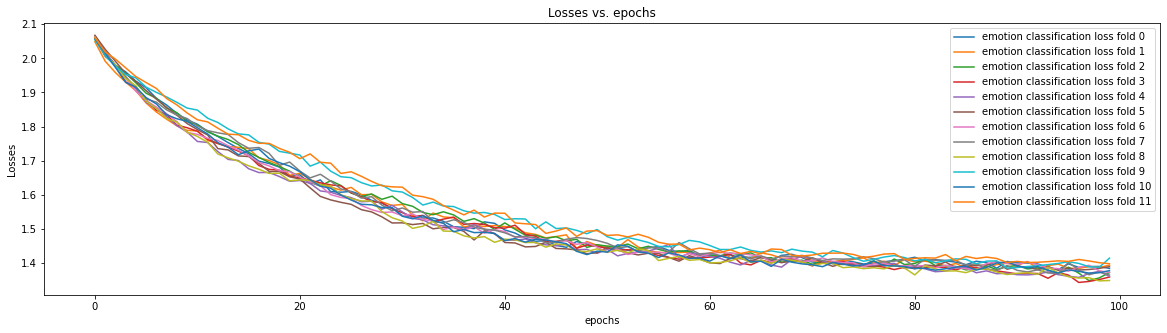

In [20]:
plt.figure(figsize=(20,5))
plt.title('Losses vs. epochs')
plt.xlabel('epochs')
plt.ylabel('Losses')

for i in range(12):
    plt.plot(range(EPOCHS), fold_emotion_class_losses[i],label='emotion classification loss fold {}'.format(i))

plt.legend(loc='best')
plt.show() 

In [21]:
def plot_accuracies_vs_epochs(fold):
    plt.figure(figsize=(20,5))
    plt.title('Accuracies vs. epochs')
    plt.xlabel('epochs')
    plt.ylabel('Losses')
    plt.plot(range(EPOCHS), fold_emotion_training_accuracies[fold],label='emotion_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[fold],label='emotion_validating_accuracies fold {}'.format(fold))
    plt.legend(loc='best')
    plt.show() 
    print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[fold])*100))
    print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[fold])*100))

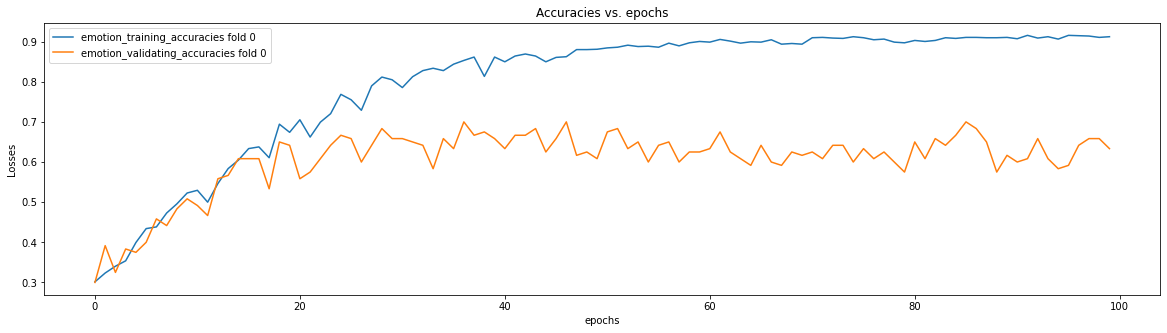

Maximum emotion training accuracy:91.55%
Maximum emotion validating accuracy:70.00%


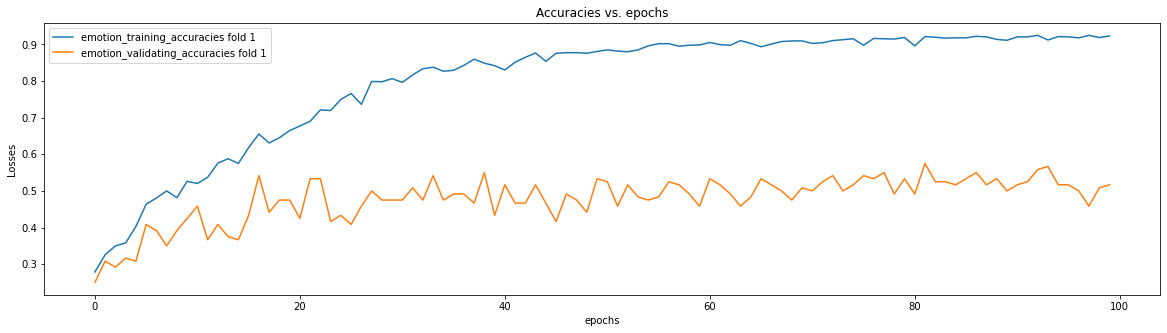

Maximum emotion training accuracy:92.48%
Maximum emotion validating accuracy:57.50%


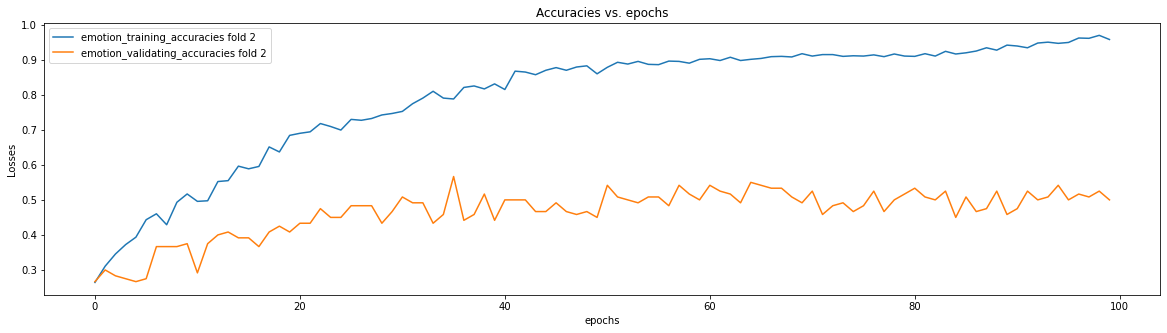

Maximum emotion training accuracy:96.96%
Maximum emotion validating accuracy:56.67%


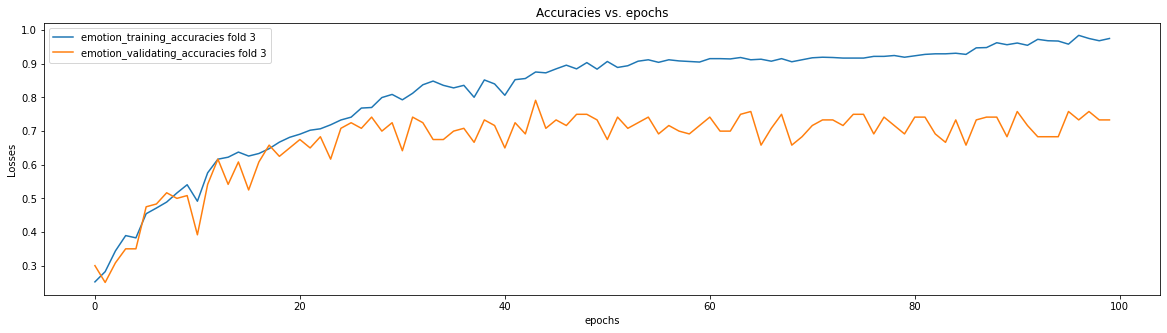

Maximum emotion training accuracy:98.48%
Maximum emotion validating accuracy:79.17%


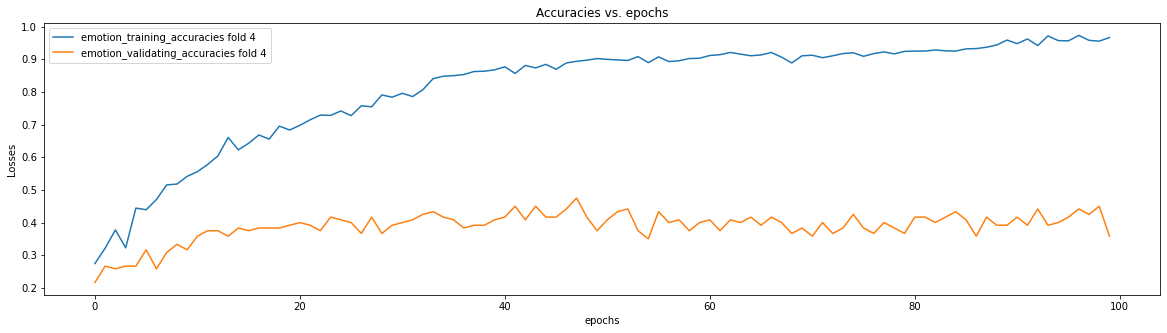

Maximum emotion training accuracy:97.30%
Maximum emotion validating accuracy:47.50%


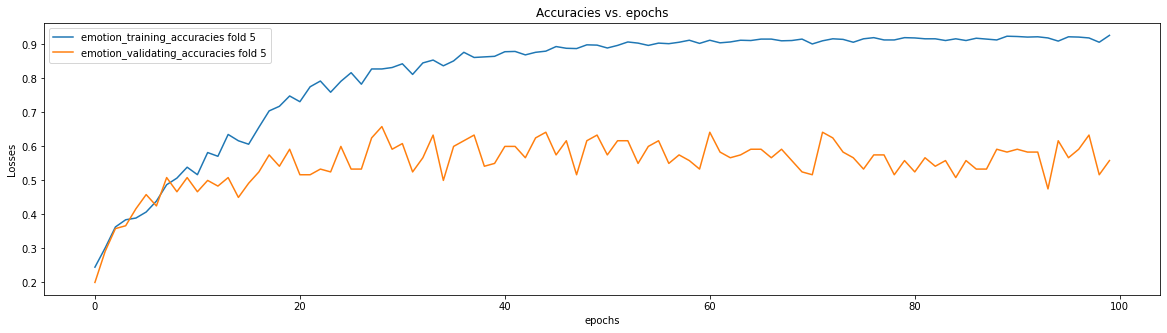

Maximum emotion training accuracy:92.65%
Maximum emotion validating accuracy:65.83%


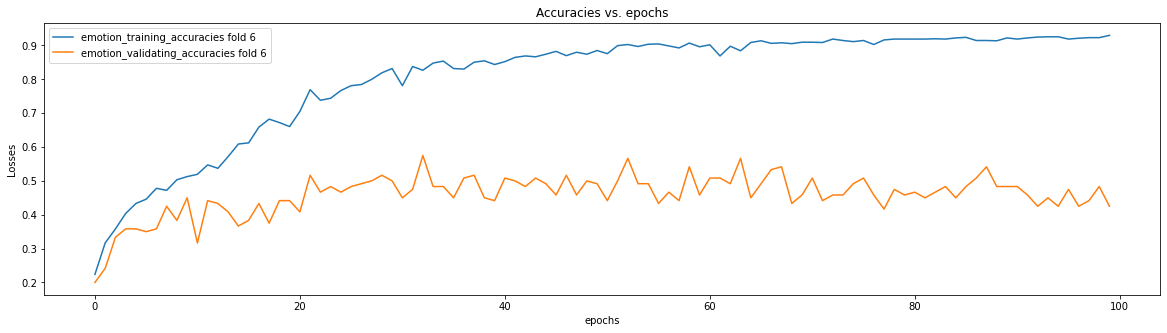

Maximum emotion training accuracy:92.99%
Maximum emotion validating accuracy:57.50%


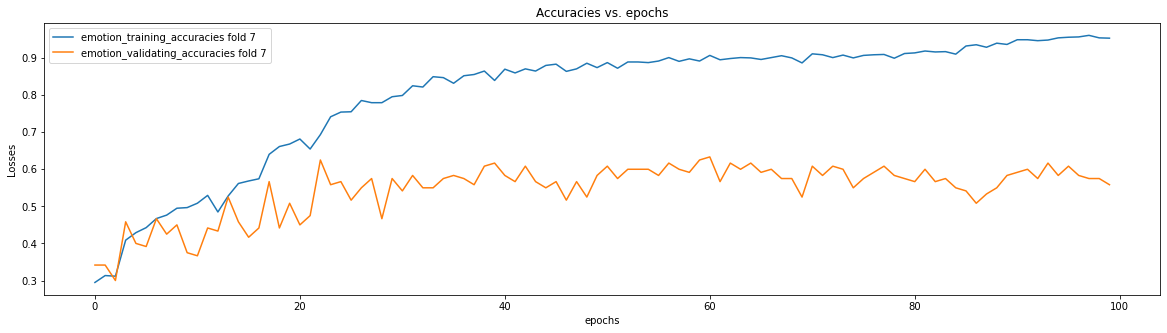

Maximum emotion training accuracy:96.11%
Maximum emotion validating accuracy:63.33%


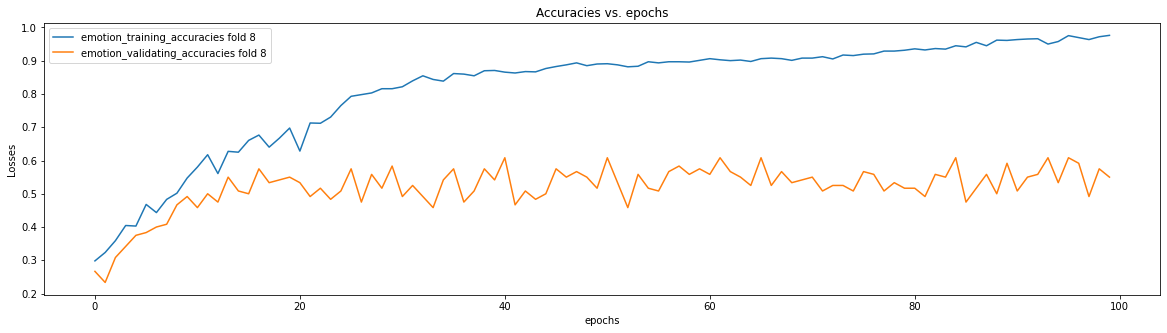

Maximum emotion training accuracy:97.64%
Maximum emotion validating accuracy:60.83%


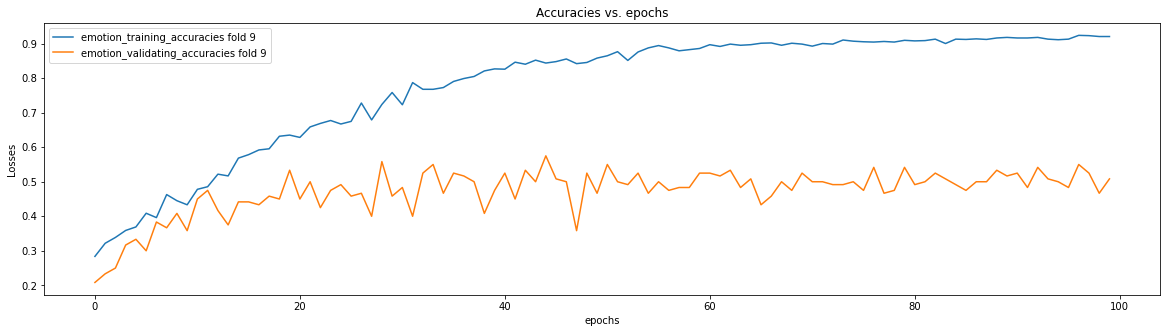

Maximum emotion training accuracy:92.40%
Maximum emotion validating accuracy:57.50%


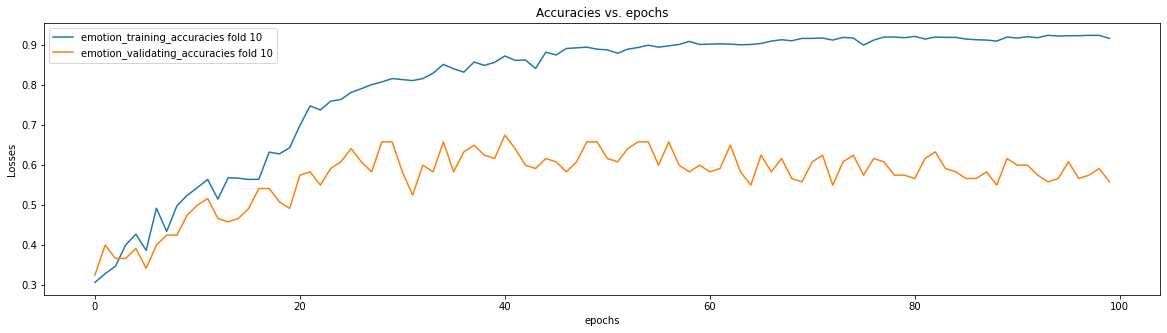

Maximum emotion training accuracy:92.48%
Maximum emotion validating accuracy:67.50%


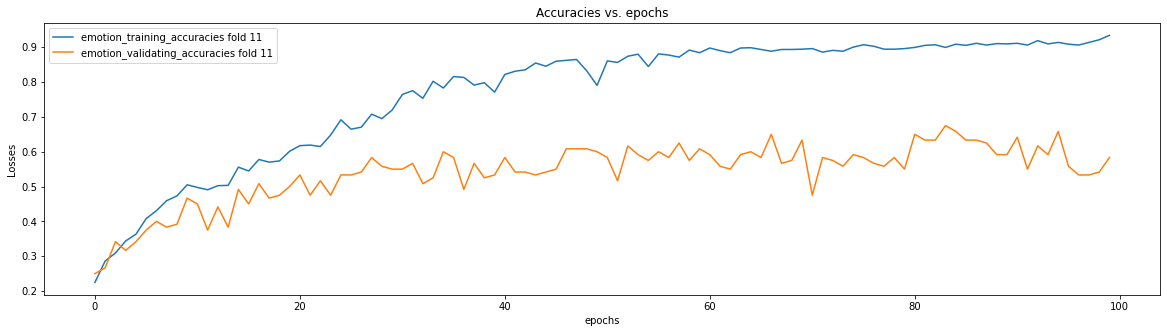

Maximum emotion training accuracy:93.41%
Maximum emotion validating accuracy:67.50%


In [22]:
for i in range(12):
    plot_accuracies_vs_epochs(i)

## 5. Loading and evaluating the model

In [23]:
from statistics import mean , stdev

lfold_emotion_training_accuracies, lfold_emotion_validating_accuracies, lfold_emotion_testing_accuracies = [] , [] , []

for fold in range(12):
    print("\nEvaluation for fold {}".format(fold))
    checkpoint = torch.load(MODEL_PATH + 'fold' + str(fold))
    
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    #speaker_classifier = SpeakerClassifier().to(DEVICE)

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    #speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    emotion_classifier.load_state_dict(checkpoint['emotion_classifier_state_dict'])
    #speaker_classifier.load_state_dict(checkpoint['speaker_classifier_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    emotion_optimizer.load_state_dict(checkpoint['emotion_optimizer_state_dict'])
    #speaker_optimizer.load_state_dict(checkpoint['speaker_optimizer_state_dict'])
    
    ravdess_dataset_train = RavdessDataset2('./Dataset/ravdess',cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2('./Dataset/ravdess',cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2('./Dataset/ravdess',cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = len(ravdess_dataset_train)
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    TEST_BATCH_SIZE = len(ravdess_dataset_test)
    
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory=True)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory=True)
    ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory=True)
    
    encoder.eval()
    emotion_classifier.eval()

    lemotion_training_correct, lemotion_validating_correct, lemotion_testing_correct = 0 , 0 , 0

    with torch.no_grad():

        # 1. Training Classification
        for index, (waveform, sample_rate, emotion, speaker) in enumerate(ravdess_train_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            lemotion_training_correct += (emotion_preds == emotion).sum() 
        emotion_training_accuracy = lemotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
        print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(lemotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))

        # 2. Validating Classification
        for index, (waveform, sample_rate, emotion, speaker) in enumerate(ravdess_validate_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            lemotion_validating_correct += (emotion_preds == emotion).sum() 
        emotion_validating_accuracy = lemotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        print("Emotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(lemotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))        


        # 3. Testing Classification
        for index, (waveform, sample_rate, emotion, speaker) in enumerate(ravdess_test_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            lemotion_testing_correct += (emotion_preds == emotion).sum() 
        emotion_testing_accuracy = lemotion_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        print("Emotion Testing Correct: {}/{} \nEmotion Testing Accuracy: {:.5f}%".format(lemotion_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),emotion_testing_accuracy*100))
        
        lfold_emotion_training_accuracies.append(emotion_training_accuracy)
        lfold_emotion_validating_accuracies.append(emotion_validating_accuracy)
        lfold_emotion_testing_accuracies.append(emotion_testing_accuracy)
    

print('\nSUMMARY:')
print('\nCV Emotion Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_training_accuracies), stdev(lfold_emotion_training_accuracies)))
print('\nCV Emotion Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_validating_accuracies), stdev(lfold_emotion_validating_accuracies)))
print('\nCV Emotion Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_testing_accuracies), stdev(lfold_emotion_testing_accuracies)))



Evaluation for fold 0
Emotion Training Correct: 1079/1200 
Emotion Training Accuracy: 89.91667%
Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Emotion Testing Correct: 73/120 
Emotion Testing Accuracy: 60.83333%

Evaluation for fold 1
Emotion Training Correct: 1066/1200 
Emotion Training Accuracy: 88.83333%
Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Emotion Testing Correct: 62/120 
Emotion Testing Accuracy: 51.66667%

Evaluation for fold 2
Emotion Training Correct: 978/1200 
Emotion Training Accuracy: 81.50000%
Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Emotion Testing Correct: 90/120 
Emotion Testing Accuracy: 75.00000%

Evaluation for fold 3
Emotion Training Correct: 1030/1200 
Emotion Training Accuracy: 85.83333%
Emotion Validating Correct: 95/120 
Emotion Validating Accuracy: 79.16667%
Emotion Testing Correct: 44/120 
Emotion Testing Accuracy: 36.66667%

Evaluation for fold 4
Emotion Traini